<a href="https://colab.research.google.com/github/duypham01/DiscretePINN/blob/main/Backwardfacingstep/Backwardfacingstep_PINN_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from collections import OrderedDict

import numpy as np
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
import time
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [ ]:
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # parameters
        self.depth = len(layers) - 1

        # set up layer order dict
        self.activation = torch.nn.Tanh

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
class PhysicsInformedNN():
    def __init__(self, X, Xb, u, v, ub, vb, layers):

        # data
        self.t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.y = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)

        self.tb = torch.tensor(Xb[:, 0:1], requires_grad=True).float().to(device)
        self.xb = torch.tensor(Xb[:, 1:2], requires_grad=True).float().to(device)
        self.yb = torch.tensor(Xb[:, 2:3], requires_grad=True).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        self.vb = torch.tensor(vb).float().to(device)

        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)

        self.lambda_1 = torch.nn.Parameter(self.lambda_1)

        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=20,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        self.losses_hist = []
        self.lambda_hist = []

    def net_u(self, x, y, t):
        outputs = self.dnn(torch.cat([t,x,y], dim=1))
        u, v, p = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        return u, v, p

    def net_f(self, x, y, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1
        u, v, p = self.net_u(x, y, t)

        u_t, u_x, u_y = torch.autograd.grad(outputs=u, inputs=[t, x, y],
                                            grad_outputs=torch.ones_like(u),
                                            retain_graph=True, create_graph=True)
        v_t, v_x, v_y = torch.autograd.grad(outputs=v, inputs=[t, x, y],
                                            grad_outputs=torch.ones_like(v),
                                            retain_graph=True, create_graph=True)
        p_x = torch.autograd.grad(outputs=p, inputs=x, grad_outputs=torch.ones_like(p),
                                  retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(outputs=p, inputs=y, grad_outputs=torch.ones_like(p),
                                  retain_graph=True, create_graph=True)[0]

        u_xx = torch.autograd.grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x),
                                   retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(outputs=u_y, inputs=y, grad_outputs=torch.ones_like(u_y),
                                   retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(outputs=v_x, inputs=x, grad_outputs=torch.ones_like(v_x),
                                   retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(outputs=v_y, inputs=y, grad_outputs=torch.ones_like(v_y),
                                   retain_graph=True, create_graph=True)[0]

        f_u = u_t - lambda_1*(u_xx + u_yy) + u*u_x + v*u_y + p_x
        f_v = v_t - lambda_1*(v_xx + v_yy) + u*v_x + v*v_y + p_y
        div_u = u_x + v_y

        return f_u, f_v, div_u

    def loss_func(self):
        start_epoch = time.time()
        u_pred, v_pred, _ = self.net_u(self.x, self.y, self.t)
        ub_pred, vb_pred, _ = self.net_u(self.xb, self.yb, self.tb)
        f_u, f_v, div_u = self.net_f(self.x, self.y, self.t)

        mse_loss = torch.nn.MSELoss()
        loss = mse_loss(f_u, torch.zeros_like(f_u)) + mse_loss(f_v, torch.zeros_like(f_v)) + \
            mse_loss(div_u, torch.zeros_like(div_u)) + mse_loss(u_pred, self.u) + mse_loss(v_pred, self.v) + \
            mse_loss(ub_pred, self.ub) + mse_loss(vb_pred, self.vb)

        self.optimizer.zero_grad()
        loss.backward()

        self.iter += 1
        self.losses_hist.append(loss.item())
        self.lambda_hist.append(self.lambda_1.item())
        print("Epoch Lbfgs [%d], Loss: %.4f, Lambda: %.4f, Time: %.4fs" % (self.iter, loss.item(), self.lambda_1.item(), time.time()-start_epoch))

        return loss

    def train(self, nIter_Adam, nIter_Lbfgs):
        self.dnn.train()
        for epoch in range(nIter_Adam):
            start_epoch = time.time()

            u_pred, v_pred, _ = self.net_u(self.x, self.y, self.t)
            f_u, f_v, div_u = self.net_f(self.x, self.y, self.t)

            mse_loss = torch.nn.MSELoss()
            loss = mse_loss(f_u, torch.zeros_like(f_u)) + mse_loss(f_v, torch.zeros_like(f_v)) + \
                    mse_loss(div_u, torch.zeros_like(div_u)) + mse_loss(u_pred, self.u) + mse_loss(v_pred, self.v)

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            self.losses_hist.append(loss.item())
            self.lambda_hist.append(self.lambda_1.item())

            print("Epoch Adam [%d], Loss: %.4f, Lambda: %.4f, Time: %.4fs" % (epoch, loss.item(), self.lambda_1.item(), time.time()-start_epoch))

        for epoch in range(nIter_Lbfgs):
            self.optimizer.step(self.loss_func)

    def predict(self, X):
        t = torch.tensor(X[:, 0:1]).float().to(device)
        x = torch.tensor(X[:, 1:2]).float().to(device)
        y = torch.tensor(X[:, 2:3]).float().to(device)

        self.dnn.eval()
        u, v, p = self.net_u(x, y, t)
        return u, v, p

In [ ]:
def plot_loss(losses, ylabel):
    epochs = len(losses)
    x_epochs = np.arange(1, epochs + 1)

    plt.figure()
    plt.plot(x_epochs, losses, color='blue')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.show()

def plot_streamlines(model, delta_x, t_value):
    # Define constants
    x = np.arange(0, 1 + delta_x, delta_x)
    y = np.arange(0, 1 + delta_x, delta_x)
    X, Y = np.meshgrid(x, y)
    t = np.full_like(X, t_value)
    grid_points = np.column_stack([t.ravel(), X.ravel(), Y.ravel()])

    # Model predictions at grid points
    # grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)
    u_pred, v_pred, _ = model.predict(grid_points)
    u = u_pred.detach().cpu().numpy().reshape(X.shape)
    v = v_pred.detach().cpu().numpy().reshape(X.shape)

    # Plot streamlines
    plt.figure(figsize=(6, 6))
    plt.streamplot(X, Y, u, v, density=1, color='b')

    # Customize plot
    plt.title(f'Streamlines at t = {t_value}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

In [ ]:
# Read inputs.txt (t, x, y)
data_inputs = np.loadtxt("inputs_txy.txt")

# Read velocity.txt (u, v, p)
data_velocity = np.loadtxt("velocity_uvp.txt")

In [ ]:
# Step 2: Generate training data based on the exact solution
def preprocess_data(data_inputs, data_velocity, T=16, delta_x=0.1, delta_y=0.1, delta_t=0.2):
    data = []
    data_bc = []
    data_dict = {}

    for idx, (t, x, y) in enumerate(data_inputs):
        data_dict[(t, x, y)] = idx

    for t, x, y in data_inputs:
        if t > T or (x < 0 and y < 0) or x == 10:
            continue

        if (x==-2):
            data_bc.append([t, x, y, 4*y*(1-y), 0])
            continue
        if (y==1 or y==-0.5):
            data_bc.append([t, x, y, 0, 0])
            continue
        if (x==0 and y<=0):
            data_bc.append([t, x, y, 0, 0])
            continue
        if (y==0 and x<=0):
            data_bc.append([t, x, y, 0, 0])
            continue


        idx = data_dict.get((t, x, y), -1)

        if idx == -1:
            continue

        u = data_velocity[idx][0]
        v = data_velocity[idx][1]

        forward_x = (t, round(x + delta_x, 5), y)
        forward_y = (t, x, round(y + delta_y, 5))
        forward_t = (round(t + delta_t, 5), x, y)

        backward_x = (t, round(x - delta_x, 5), y)
        backward_y = (t, x, round(y - delta_y, 5))

        u_forward_x, v_forward_x = get_velocity(data_dict, data_velocity, forward_x)
        u_forward_y, v_forward_y = get_velocity(data_dict, data_velocity, forward_y)
        u_forward_t, v_forward_t = get_velocity(data_dict, data_velocity, forward_t)
        u_backward_x, v_backward_x = get_velocity(data_dict, data_velocity, backward_x)
        u_backward_y, v_backward_y = get_velocity(data_dict, data_velocity, backward_y)

        u_t = (u_forward_t - u) / delta_t
        v_t = (v_forward_t - v) / delta_t
        u_x = (u_forward_x - u) / delta_x
        v_x = (v_forward_x - v) / delta_x
        u_y = (u_forward_y - u) / delta_y
        v_y = (v_forward_y - v) / delta_y

        u_xx = (u_forward_x + u_backward_x - 2 * u) / (delta_x ** 2)
        u_yy = (u_forward_y + u_backward_y - 2 * u) / (delta_y ** 2)
        v_xx = (v_forward_x + v_backward_x - 2 * v) / (delta_x ** 2)
        v_yy = (v_forward_y + v_backward_y - 2 * v) / (delta_y ** 2)

        data.append([t, x, y, u, v, u_t, v_t, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy])

    return np.array(data, dtype=np.float32), np.array(data_bc, dtype=np.float32)


def get_velocity(data_dict, data_velocity, coords):
    idx = data_dict.get((coords[0], round(coords[1], 5), round(coords[2], 5)), -1)
    if idx == -1:
        print(coords)
        return np.nan, np.nan
    else:
        return data_velocity[idx][0], data_velocity[idx][1]


# Example usage:
delta_y = 0.1
delta_x = 0.2
delta_t = 0.2

# Assuming data_inputs and data_velocity are defined somewhere
data, data_bc = preprocess_data(data_inputs, data_velocity, T=7, delta_x=delta_x, delta_y=delta_y, delta_t=delta_t)
print(data)
print(data.shape)
is_nan = np.count_nonzero(np.isnan(data))
print(is_nan)

print(data_bc)
print(data_bc.shape)
is_nan = np.count_nonzero(np.isnan(data_bc))
print(is_nan)

[[  0.          -1.8          0.1        ... -10.1717       0.06417
    4.47793   ]
 [  0.          -1.8          0.2        ...  10.3611      -0.0232025
    1.49649   ]
 [  0.          -1.8          0.3        ...  15.035        0.32611
    2.26491   ]
 ...
 [  7.           9.8          0.7        ...  -7.8627      -0.02973659
    0.1277541 ]
 [  7.           9.8          0.8        ...  -0.9419      -0.06811236
   -0.0972465 ]
 [  7.           9.8          0.9        ...  -2.1375642   -0.0596245
   -0.0921705 ]]
(27936, 15)
0
[[ 0.   -2.    0.    0.    0.  ]
 [ 0.   -2.    0.1   0.36  0.  ]
 [ 0.   -2.    0.2   0.64  0.  ]
 ...
 [ 7.    9.6   1.    0.    0.  ]
 [ 7.    9.8  -0.5   0.    0.  ]
 [ 7.    9.8   1.    0.    0.  ]]
(4824, 5)
0


In [ ]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
print(device)

cuda


Epoch Lbfgs [1], Loss: 0.2846, Lambda: 0.0000, Time: 1.1986s
Epoch Lbfgs [2], Loss: 0.1971, Lambda: 0.0000, Time: 0.8501s
Epoch Lbfgs [3], Loss: 0.1606, Lambda: 0.0000, Time: 0.8450s
Epoch Lbfgs [4], Loss: 0.1601, Lambda: 0.0000, Time: 0.8453s
Epoch Lbfgs [5], Loss: 0.1569, Lambda: 0.0001, Time: 0.8460s
Epoch Lbfgs [6], Loss: 0.1553, Lambda: 0.0001, Time: 0.8486s
Epoch Lbfgs [7], Loss: 0.1550, Lambda: 0.0001, Time: 0.8462s
Epoch Lbfgs [8], Loss: 0.1540, Lambda: 0.0001, Time: 0.8459s
Epoch Lbfgs [9], Loss: 0.1537, Lambda: 0.0000, Time: 0.8465s
Epoch Lbfgs [10], Loss: 0.1532, Lambda: -0.0001, Time: 0.8458s
Epoch Lbfgs [11], Loss: 0.1530, Lambda: -0.0002, Time: 0.8457s
Epoch Lbfgs [12], Loss: 0.1528, Lambda: -0.0005, Time: 0.8453s
Epoch Lbfgs [13], Loss: 0.1525, Lambda: -0.0009, Time: 0.8495s
Epoch Lbfgs [14], Loss: 0.1521, Lambda: -0.0017, Time: 0.8454s
Epoch Lbfgs [15], Loss: 0.1515, Lambda: -0.0029, Time: 0.8478s
Epoch Lbfgs [16], Loss: 0.1505, Lambda: -0.0053, Time: 0.8465s
Epoch Lbfg

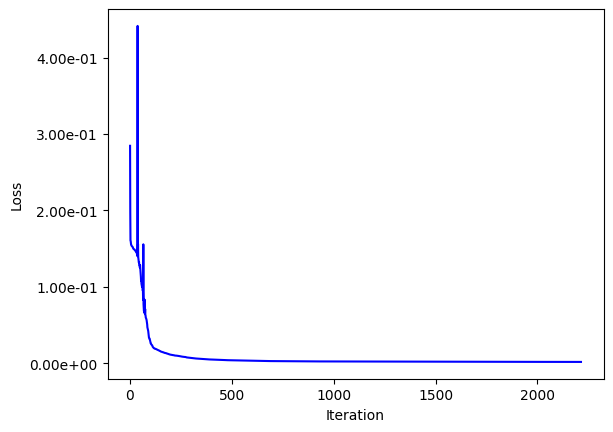

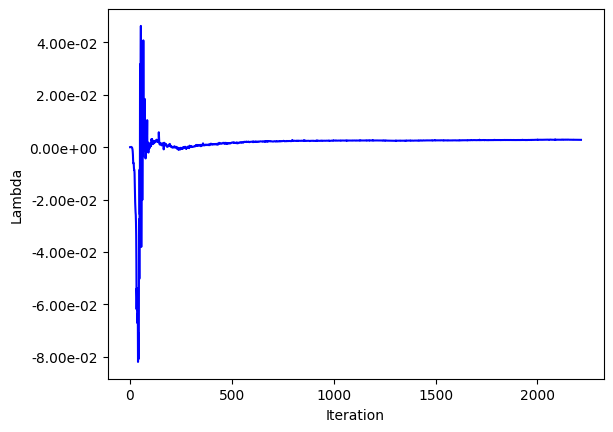

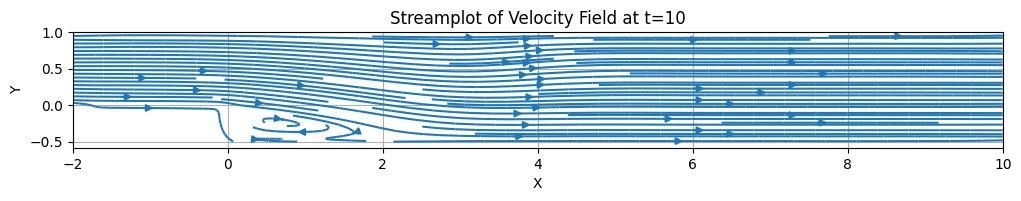

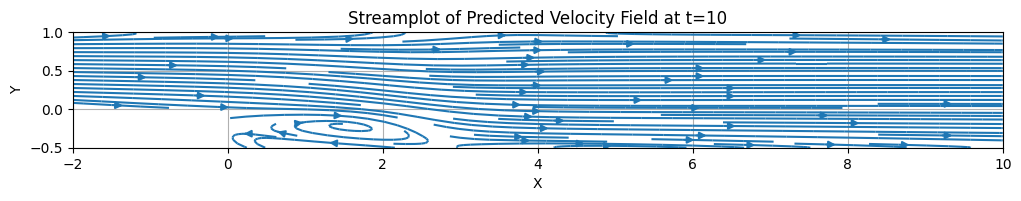

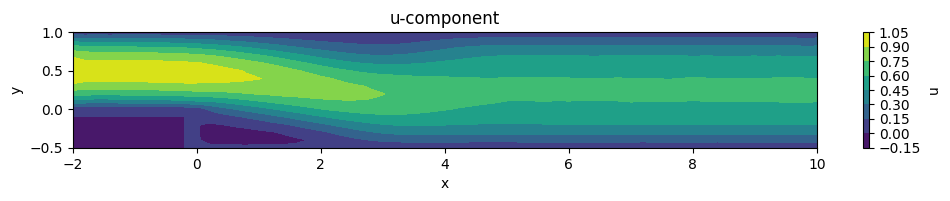

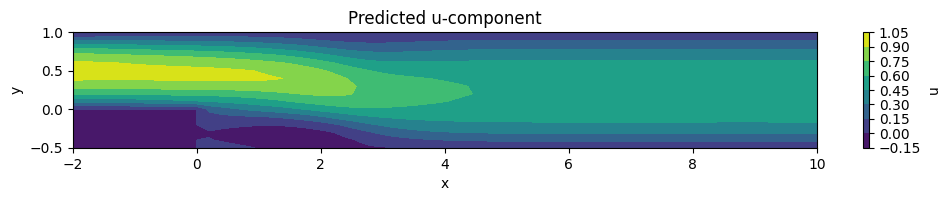

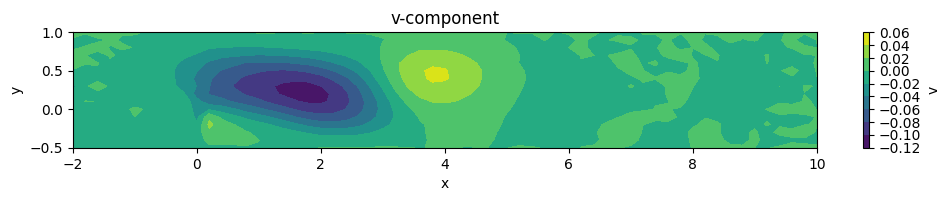

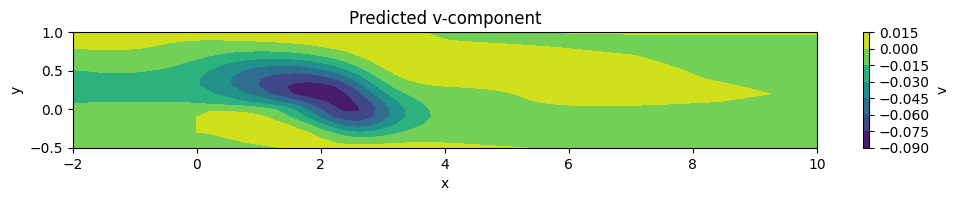

In [ ]:
# adam 0.84s per
# lbfgs 0.84s
layers = [3, 16, 16, 16, 16, 16, 3]
X_train = data[:,0:3]
U = data[:,3]
V = data[:,4]

Xb_train = data_bc[:,0:3]
Ub = data_bc[:,3]
Vb = data_bc[:,4]

# training
model = PhysicsInformedNN(X_train, Xb_train, U, V, Ub, Vb, layers)
model.train(0, 100)

# Test data generation
# Filter data where t > 7, t<=10
mask = (data_inputs[:, 0] > 7) & (data_inputs[:, 0] <= 10)
data_filtered_inputs = data_inputs[mask]
data_filtered_velocity = torch.tensor(data_velocity[mask], dtype=torch.float32, requires_grad=False).to(device)

# Predict u and v using the model
u_pred, v_pred, _ = model.predict(data_filtered_inputs)

# Calculate MSE for u and v
mse_loss = torch.nn.MSELoss()
L2 = mse_loss(u_pred, data_filtered_velocity[:, 0]) + mse_loss(v_pred, data_filtered_velocity[:, 1])
print("L2 = ", L2)

print("lambda = ", model.lambda_1)

# Plot loss history
plot_loss(model.losses_hist, ylabel='Loss')

# Plot lambda history
plot_loss(model.lambda_hist, ylabel='Lambda')

# Plot streamlines
# Generate meshgrid
x_range = np.arange(-2, 10.0 + delta_x, delta_x)
y_range = np.arange(-0.5, 1.0 + delta_y, delta_y)
X, Y = np.meshgrid(x_range, y_range)

# Helper function to match values
def match_values(X, Y, xy, uv):
    U = np.zeros_like(X)
    V = np.zeros_like(X)
    rounded_xy = np.round(xy, decimals=5)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            row_to_match = np.round([X[i, j], Y[i, j]], decimals=5)
            index = np.where((rounded_xy == row_to_match).all(axis=1))[0]
            if index.size > 0:
                U[i, j] = uv[index[0], 0]
                V[i, j] = uv[index[0], 1]
    return U, V

# Filter data for specific t
T = 10
t_index = np.where(data_inputs[:, 0] == T)[0]
xy = data_inputs[t_index, 1:]
uv = data_velocity[t_index, :2]

# Match values and create streamplot
U, V = match_values(X, Y, xy, uv)

plt.figure(figsize=(12, 1.5))
plt.streamplot(X, Y, U, V)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Streamplot of Velocity Field at t={T}')
plt.grid(True)
plt.show()

# Create input points for prediction (t=20)
input_points = np.column_stack((np.full_like(X.flatten(), T), X.flatten(), Y.flatten()))
input_points = torch.tensor(input_points, dtype=torch.float32, requires_grad=False).to(device)

# Predict u and v using the model
u_pred, v_pred, _ = model.predict(input_points)

# Reshape predicted values to match the shape of X and Y
U_pred = u_pred.detach().cpu().reshape(X.shape)
V_pred = v_pred.detach().cpu().reshape(X.shape)

# Set predicted values to 0 where conditions are met
mask = (X <= 0) & (Y <= 0)
U_pred[mask] = 0
V_pred[mask] = 0

# Plot the predicted streamplot
plt.figure(figsize=(12, 1.5))
plt.streamplot(X, Y, U_pred, V_pred)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Streamplot of Predicted Velocity Field at t={T}')
plt.grid(True)
plt.show()

# Function for contour plot
def plot_contour(X, Y, Z, title, label):
    plt.figure(figsize=(12, 1.5))
    contour = plt.contourf(X, Y, Z, cmap='viridis')
    plt.colorbar(contour, label=label)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Plot u and v components
plot_contour(X, Y, U, 'u-component', 'u')
plot_contour(X, Y, U_pred, 'Predicted u-component', 'u')
plot_contour(X, Y, V, 'v-component', 'v')
plot_contour(X, Y, V_pred, 'Predicted v-component', 'v')

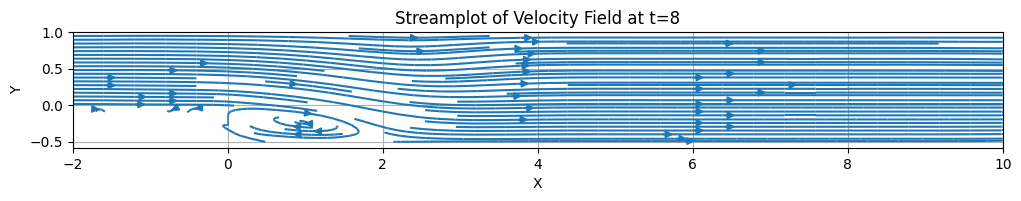

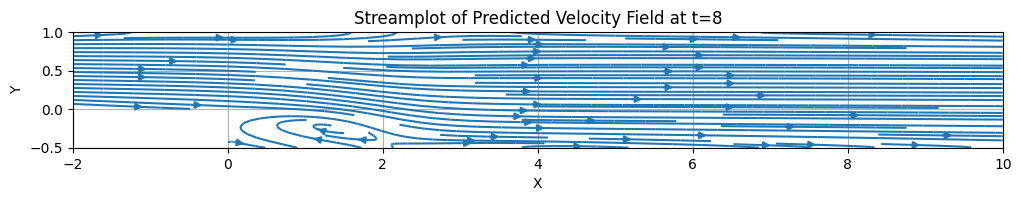

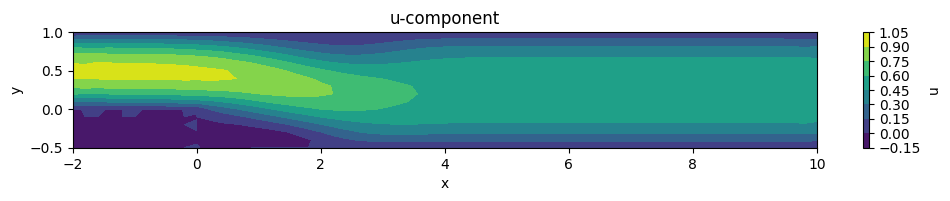

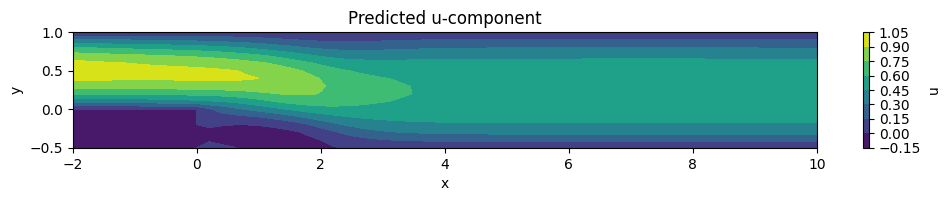

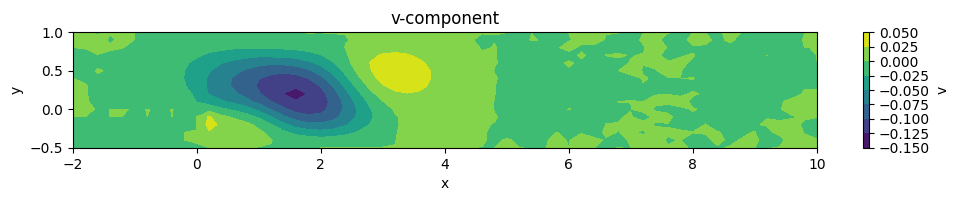

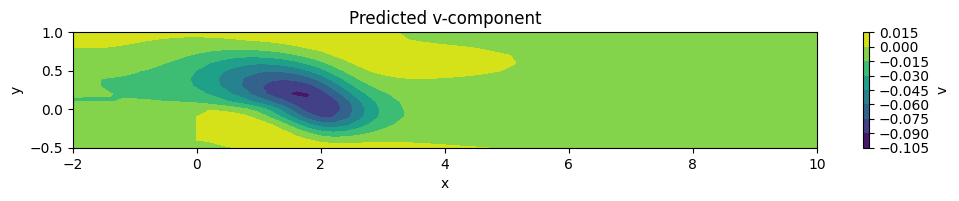

In [ ]:
# Filter data for specific t
T = 8
t_index = np.where(data_inputs[:, 0] == T)[0]
xy = data_inputs[t_index, 1:]
uv = data_velocity[t_index, :2]

# Match values and create streamplot
U, V = match_values(X, Y, xy, uv)

plt.figure(figsize=(12, 1.5))
plt.streamplot(X, Y, U, V)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Streamplot of Velocity Field at t={T}')
plt.grid(True)
plt.show()

# Create input points for prediction (t=20)
input_points = np.column_stack((np.full_like(X.flatten(), T), X.flatten(), Y.flatten()))
input_points = torch.tensor(input_points, dtype=torch.float32, requires_grad=False).to(device)

# Predict u and v using the model
u_pred, v_pred, _ = model.predict(input_points)

# Reshape predicted values to match the shape of X and Y
U_pred = u_pred.detach().cpu().reshape(X.shape)
V_pred = v_pred.detach().cpu().reshape(X.shape)

# Set predicted values to 0 where conditions are met
mask = (X <= 0) & (Y <= 0)
U_pred[mask] = 0
V_pred[mask] = 0

# Plot the predicted streamplot
plt.figure(figsize=(12, 1.5))
plt.streamplot(X, Y, U_pred, V_pred)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Streamplot of Predicted Velocity Field at t={T}')
plt.grid(True)
plt.show()

# Function for contour plot
def plot_contour(X, Y, Z, title, label):
    plt.figure(figsize=(12, 1.5))
    contour = plt.contourf(X, Y, Z, cmap='viridis')
    plt.colorbar(contour, label=label)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Plot u and v components
plot_contour(X, Y, U, 'u-component', 'u')
plot_contour(X, Y, U_pred, 'Predicted u-component', 'u')
plot_contour(X, Y, V, 'v-component', 'v')
plot_contour(X, Y, V_pred, 'Predicted v-component', 'v')

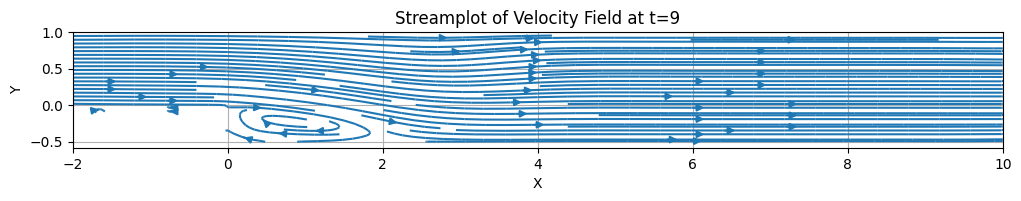

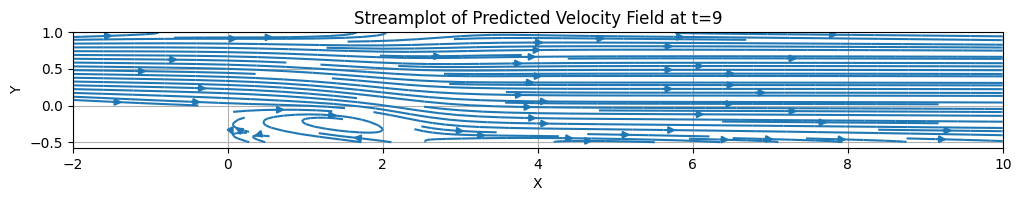

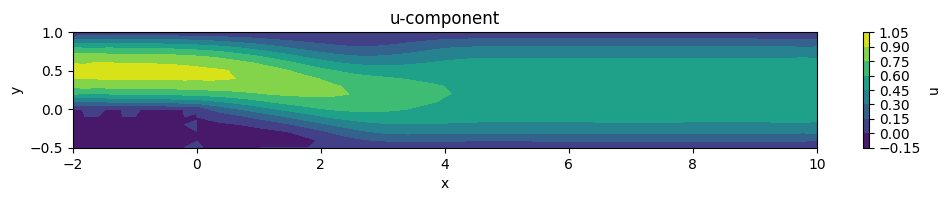

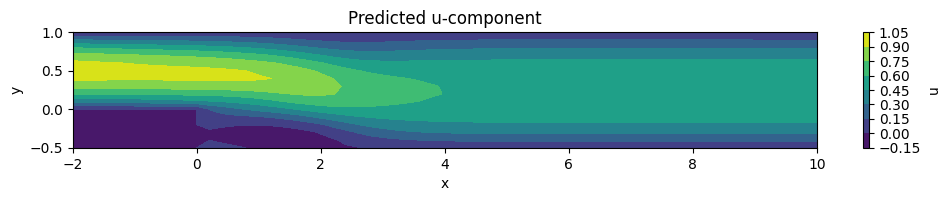

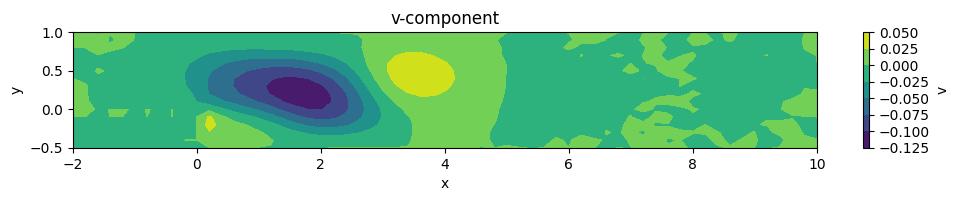

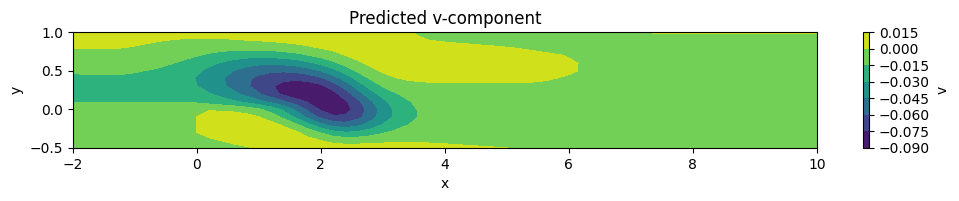

In [ ]:
# Filter data for specific t
T = 9
t_index = np.where(data_inputs[:, 0] == T)[0]
xy = data_inputs[t_index, 1:]
uv = data_velocity[t_index, :2]

# Match values and create streamplot
U, V = match_values(X, Y, xy, uv)

plt.figure(figsize=(12, 1.5))
plt.streamplot(X, Y, U, V)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Streamplot of Velocity Field at t={T}')
plt.grid(True)
plt.show()

# Create input points for prediction (t=20)
input_points = np.column_stack((np.full_like(X.flatten(), T), X.flatten(), Y.flatten()))
input_points = torch.tensor(input_points, dtype=torch.float32, requires_grad=False).to(device)

# Predict u and v using the model
u_pred, v_pred, _ = model.predict(input_points)

# Reshape predicted values to match the shape of X and Y
U_pred = u_pred.detach().cpu().reshape(X.shape)
V_pred = v_pred.detach().cpu().reshape(X.shape)

# Set predicted values to 0 where conditions are met
mask = (X <= 0) & (Y <= 0)
U_pred[mask] = 0
V_pred[mask] = 0

# Plot the predicted streamplot
plt.figure(figsize=(12, 1.5))
plt.streamplot(X, Y, U_pred, V_pred)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Streamplot of Predicted Velocity Field at t={T}')
plt.grid(True)
plt.show()

# Function for contour plot
def plot_contour(X, Y, Z, title, label):
    plt.figure(figsize=(12, 1.5))
    contour = plt.contourf(X, Y, Z, cmap='viridis')
    plt.colorbar(contour, label=label)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Plot u and v components
plot_contour(X, Y, U, 'u-component', 'u')
plot_contour(X, Y, U_pred, 'Predicted u-component', 'u')
plot_contour(X, Y, V, 'v-component', 'v')
plot_contour(X, Y, V_pred, 'Predicted v-component', 'v')